# NBME - Score Clinical Patient Notes
In the last notebook, I used bert base model and got accuracy like 0.83 on PB.
Here is the [notebook link](https://www.kaggle.com/iamsdt/pytorch-bert-baseline-nbme)

In this notebook, let's use RoBERTa.


### Bert vs RoBERTa
From RoBERTa original Paper
> BERT relies on randomly masking and predicting tokens. The original BERT implementation performed masking
once during data preprocessing, resulting in a single static mask. To avoid using the same mask for
each training instance in every epoch, training data
was duplicated 10 times so that each sequence is
masked in 10 different ways over the 40 epochs of
training. Thus, each training sequence was seen
with the same mask four times during training.

>We compare this strategy with dynamic masking where we generate the masking pattern every
time we feed a sequence to the model. This becomes crucial when pretraining for more steps or
with larger datasets. We find that our reimplementation
with static masking performs similar to the
original BERT model, and dynamic masking is
comparable or slightly better than static masking.
Given these results and the additional efficiency
benefits of dynamic masking, we use dynamic
masking in the remainder of the experiments

Results:

|  Masking   |   | SQuAD 2.0   |  MNLI-m |  SST-2 |
|---|---|---|---|---|
|  reference    |   | 76.3  | 84.3  | 92.8  |
|  static |   |  78.3  |  84.3 | 92.5  |
|  dynamic    |   | 78.7  |  84.0 |  92.9 |



RoBERTa [paper Link](https://arxiv.org/abs/1907.11692)

Not that much improvement, if we compared with Bert vs RoBERTa, slight improvement only

- **Framework:** Pytorch
- **Model Architecture:**
    - RoBERTa
    - Linear(768, 512)
    - Linear(512, 512)
    - Linear(512, 1)
- **LR:** 1e-5
- **Batch Size:** 8
- **Epoch:** 5
- **Dropout:** 0.2
- **Criterion:** BCEWithLogitsLoss
- **Optimizer:** AdamW

# Tokenizer params
- **Max Lenght:** 416
- **Padding:** max_lenght
- **Truncation:** only_scond

In [1]:
from ast import literal_eval
from itertools import chain

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer, RobertaTokenizerFast, RobertaModel

# Helper Functions
### 1. Datasets Helper Function
need to merge `features.csv`, `patient_notes.csv` with `train.csv`

In [2]:
BASE_URL = "../input/nbme-score-clinical-patient-notes"


def process_feature_text(text):
    return text.replace("-OR-", ";-").replace("-", " ")


def prepare_datasets():
    features = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    df = pd.read_csv(f"{BASE_URL}/train.csv")
    df["annotation_list"] = [literal_eval(x) for x in df["annotation"]]
    df["location_list"] = [literal_eval(x) for x in df["location"]]

    merged = df.merge(notes, how="left")
    merged = merged.merge(features, how="left")

    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    merged["feature_text"] = merged["feature_text"].apply(lambda x: x.lower())
    merged["pn_history"] = merged["pn_history"].apply(lambda x: x.lower())

    return merged

### 2. Tokenizer Helper Function

In [3]:
def loc_list_to_ints(loc_list):
    to_return = []
    for loc_str in loc_list:
        loc_strs = loc_str.split(";")
        for loc in loc_strs:
            start, end = loc.split()
            to_return.append((int(start), int(end)))
    return to_return


def tokenize_and_add_labels(tokenizer, data, config):
    out = tokenizer(
        data["feature_text"],
        data["pn_history"],
        truncation=config['truncation'],
        max_length=config['max_length'],
        padding=config['padding'],
        return_offsets_mapping=config['return_offsets_mapping']
    )
    labels = [0.0] * len(out["input_ids"])
    out["location_int"] = loc_list_to_ints(data["location_list"])
    out["sequence_ids"] = out.sequence_ids()

    for idx, (seq_id, offsets) in enumerate(zip(out["sequence_ids"], out["offset_mapping"])):
        if not seq_id or seq_id == 0:
            labels[idx] = -1
            continue

        token_start, token_end = offsets
        for feature_start, feature_end in out["location_int"]:
            if token_start >= feature_start and token_end <= feature_end:
                labels[idx] = 1.0
                break

    out["labels"] = labels

    return out

### 3. Predection and Score Helper Function

In [4]:
from sklearn.metrics import accuracy_score

def get_location_predictions(preds, offset_mapping, sequence_ids, test=False):
    all_predictions = []
    for pred, offsets, seq_ids in zip(preds, offset_mapping, sequence_ids):
        pred = 1 / (1 + np.exp(-pred))
        start_idx = None
        end_idx = None
        current_preds = []
        for pred, offset, seq_id in zip(pred, offsets, seq_ids):
            if seq_id is None or seq_id == 0:
                continue

            if pred > 0.5:
                if start_idx is None:
                    start_idx = offset[0]
                end_idx = offset[1]
            elif start_idx is not None:
                if test:
                    current_preds.append(f"{start_idx} {end_idx}")
                else:
                    current_preds.append((start_idx, end_idx))
                start_idx = None
        if test:
            all_predictions.append("; ".join(current_preds))
        else:
            all_predictions.append(current_preds)
            
    return all_predictions


def calculate_char_cv(predictions, offset_mapping, sequence_ids, labels):
    all_labels = []
    all_preds = []
    for preds, offsets, seq_ids, labels in zip(predictions, offset_mapping, sequence_ids, labels):

        num_chars = max(list(chain(*offsets)))
        char_labels = np.zeros(num_chars)

        for o, s_id, label in zip(offsets, seq_ids, labels):
            if s_id is None or s_id == 0:
                continue
            if int(label) == 1:
                char_labels[o[0]:o[1]] = 1

        char_preds = np.zeros(num_chars)

        for start_idx, end_idx in preds:
            char_preds[start_idx:end_idx] = 1

        all_labels.extend(char_labels)
        all_preds.extend(char_preds)

    results = precision_recall_fscore_support(all_labels, all_preds, average="binary", labels=np.unique(all_preds))
    accuracy = accuracy_score(all_labels, all_preds)
    

    return {
        "Accuracy": accuracy,
        "precision": results[0],
        "recall": results[1],
        "f1": results[2]
    }

# Dataset

In [5]:
class CustomDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data.iloc[idx]
        tokens = tokenize_and_add_labels(self.tokenizer, data, self.config)

        input_ids = np.array(tokens["input_ids"])
        attention_mask = np.array(tokens["attention_mask"])
#         token_type_ids = __getitem__np.array(tokens["token_type_ids"])

        labels = np.array(tokens["labels"])
        offset_mapping = np.array(tokens['offset_mapping'])
        sequence_ids = np.array(tokens['sequence_ids']).astype("float16")
        
        return input_ids, attention_mask, labels, offset_mapping, sequence_ids

# Model
- Lets use **BERT** base Architecture
- Also Used 3 FC layers

**Comments:** 3 layers improve accuracy 2% on public score

In [6]:
class CustomModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.bert = RobertaModel.from_pretrained(config['model_name'])  # BERT model
        self.dropout = nn.Dropout(p=config['dropout'])
        self.config = config
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        logits = self.fc1(outputs[0])
        logits = self.fc2(self.dropout(logits))
        logits = self.fc3(self.dropout(logits)).squeeze(-1)
        return logits

## Hyperparameters


In [7]:
hyperparameters = {
    "max_length": 416,
    "padding": "max_length",
    "return_offsets_mapping": True,
    "truncation": "only_second",
    "model_name": "../input/huggingface-roberta-variants/roberta-base/roberta-base",
    "dropout": 0.2,
    "lr": 1e-5,
    "test_size": 0.2,
    "seed": 1268,
    "batch_size": 8
}

# Prepare Datasets
Train and Test split: 20%

Total Data:
- Train: 11440
- Test: 2860

In [8]:
train_df = prepare_datasets()

# train_df = train_df[: int(train_df.shape[0] * 0.5)]

X_train, X_test = train_test_split(train_df, test_size=hyperparameters['test_size'],
                                   random_state=hyperparameters['seed'])


print("Train size", len(X_train))
print("Test Size", len(X_test))

Train size 11440
Test Size 2860


In [9]:
tokenizer = RobertaTokenizerFast.from_pretrained(hyperparameters['model_name'])

training_data = CustomDataset(X_train, tokenizer, hyperparameters)
train_dataloader = DataLoader(training_data, batch_size=hyperparameters['batch_size'], shuffle=True)

test_data = CustomDataset(X_test, tokenizer, hyperparameters)
test_dataloader = DataLoader(test_data, batch_size=hyperparameters['batch_size'], shuffle=False)

# Train
Lets train the model
with BCEWithLogitsLoss and AdamW as optimizer

**Notes:** on BCEWithLogitsLoss, the default value for reduction is `mean` (the sum of the output will be divided by the number of elements in the output). If we use this default value, it will produce negative loss. Because we have some negative labels. To fix this negative loss issue, we can use `none` as parameter. To calculate the mean, first, we have to filter out the negative values. [DOC](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)

In [10]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = CustomModel(hyperparameters).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss(reduction = "none")
optimizer = optim.AdamW(model.parameters(), lr=hyperparameters['lr'])

Some weights of the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [11]:
def train_model(model, dataloader, optimizer, criterion):
        model.train()
        train_loss = []

        for batch in tqdm(dataloader):
            optimizer.zero_grad()
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
#             token_type_ids = batch[2].to(DEVICE)
            labels = batch[2].to(DEVICE)

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            # since, we have
            loss = torch.masked_select(loss, labels > -1.0).mean()
            train_loss.append(loss.item() * input_ids.size(0))
            loss.backward()
            # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
            # it's also improve f1 accuracy slightly
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        return sum(train_loss)/len(train_loss)

In [12]:
def eval_model(model, dataloader, criterion):
        model.eval()
        valid_loss = []
        preds = []
        offsets = []
        seq_ids = []
        valid_labels = []

        for batch in tqdm(dataloader):
            input_ids = batch[0].to(DEVICE)
            attention_mask = batch[1].to(DEVICE)
#             token_type_ids = batch[2].to(DEVICE)
            labels = batch[2].to(DEVICE)
            offset_mapping = batch[3]
            sequence_ids = batch[4]

            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            loss = torch.masked_select(loss, labels > -1.0).mean()
            valid_loss.append(loss.item() * input_ids.size(0))

            preds.append(logits.detach().cpu().numpy())
            offsets.append(offset_mapping.numpy())
            seq_ids.append(sequence_ids.numpy())
            valid_labels.append(labels.detach().cpu().numpy())

        preds = np.concatenate(preds, axis=0)
        offsets = np.concatenate(offsets, axis=0)
        seq_ids = np.concatenate(seq_ids, axis=0)
        valid_labels = np.concatenate(valid_labels, axis=0)
        location_preds = get_location_predictions(preds, offsets, seq_ids, test=False)
        score = calculate_char_cv(location_preds, offsets, seq_ids, valid_labels)

        return sum(valid_loss)/len(valid_loss), score

In [13]:
import time

train_loss_data, valid_loss_data = [], []
score_data_list = []
valid_loss_min = np.Inf
since = time.time()
epochs = 3

In [14]:
best_loss = np.inf

for i in range(epochs):
    print("Epoch: {}/{}".format(i + 1, epochs))
    # first train model
    train_loss = train_model(model, train_dataloader, optimizer, criterion)
    train_loss_data.append(train_loss)
    print(f"Train loss: {train_loss}")
    # evaluate model
    valid_loss, score = eval_model(model, test_dataloader, criterion)
    valid_loss_data.append(valid_loss)
    score_data_list.append(score)
    print(f"Valid loss: {valid_loss}")
    print(f"Valid score: {score}")
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "nbme_bert_v2.pth")

    
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.31856258368576557


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.13456827887986766
Valid score: {'Accuracy': 0.992769353442345, 'precision': 0.8027290181020296, 'recall': 0.6770770076053324, 'f1': 0.7345683853864374}
Epoch: 2/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.11553747134466871


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.10811723652985188
Valid score: {'Accuracy': 0.9938141457615617, 'precision': 0.7735299719735518, 'recall': 0.8220699227899714, 'f1': 0.7970616273201369}
Epoch: 3/3


  0%|          | 0/1430 [00:00<?, ?it/s]

Train loss: 0.08322859278637305


  0%|          | 0/358 [00:00<?, ?it/s]

Valid loss: 0.11577702006114562
Valid score: {'Accuracy': 0.9942290714637947, 'precision': 0.8052369366237979, 'recall': 0.8039096613747434, 'f1': 0.804572751609869}
Training completed in 33m 8s


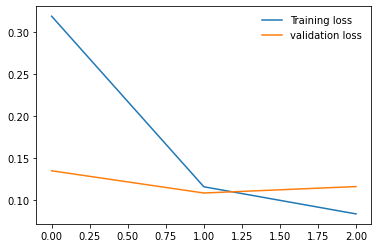

In [15]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [16]:
import pandas as pd

score_df = pd.DataFrame.from_dict(score_data_list)
score_df.head()

,Accuracy,precision,recall,f1
0,0.992769,0.802729,0.677077,0.734568
1,0.993814,0.773530,0.822070,0.797062
2,0.994229,0.805237,0.803910,0.804573


# Prepare For Testing

Load best model

In [17]:
model.load_state_dict(torch.load("nbme_bert_v2.pth", map_location = DEVICE))

<All keys matched successfully>

In [18]:
def create_test_df():
    feats = pd.read_csv(f"{BASE_URL}/features.csv")
    notes = pd.read_csv(f"{BASE_URL}/patient_notes.csv")
    test = pd.read_csv(f"{BASE_URL}/test.csv")

    merged = test.merge(notes, how = "left")
    merged = merged.merge(feats, how = "left")

    def process_feature_text(text):
        return text.replace("-OR-", ";-").replace("-", " ")
    
    merged["feature_text"] = [process_feature_text(x) for x in merged["feature_text"]]
    
    return merged


class SubmissionDataset(Dataset):
    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        example = self.data.loc[idx]
        tokenized = self.tokenizer(
            example["feature_text"],
            example["pn_history"],
            truncation = self.config['truncation'],
            max_length = self.config['max_length'],
            padding = self.config['padding'],
            return_offsets_mapping = self.config['return_offsets_mapping']
        )
        tokenized["sequence_ids"] = tokenized.sequence_ids()

        input_ids = np.array(tokenized["input_ids"])
        attention_mask = np.array(tokenized["attention_mask"])
        offset_mapping = np.array(tokenized["offset_mapping"])
        sequence_ids = np.array(tokenized["sequence_ids"]).astype("float16")

        return input_ids, attention_mask, offset_mapping, sequence_ids


test_df = create_test_df()

submission_data = SubmissionDataset(test_df, tokenizer, hyperparameters)
submission_dataloader = DataLoader(submission_data, batch_size=hyperparameters['batch_size'], shuffle=False)

In [19]:
model.eval()
preds = []
offsets = []
seq_ids = []

for batch in tqdm(submission_dataloader):
    input_ids = batch[0].to(DEVICE)
    attention_mask = batch[1].to(DEVICE)
    offset_mapping = batch[2]
    sequence_ids = batch[3]

    logits = model(input_ids, attention_mask)
    
    preds.append(logits.detach().cpu().numpy())
    offsets.append(offset_mapping.numpy())
    seq_ids.append(sequence_ids.numpy())

preds = np.concatenate(preds, axis=0)
offsets = np.concatenate(offsets, axis=0)
seq_ids = np.concatenate(seq_ids, axis=0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
location_preds = get_location_predictions(preds, offsets, seq_ids, test=True)

In [21]:
len(location_preds), len(test_df)

(5, 5)

In [22]:
test_df["location"] = location_preds

In [23]:
test_df[["id", "location"]].to_csv("submission.csv", index = False)
pd.read_csv("submission.csv").head()

,id,location
0,00016_000,696 724
1,00016_001,668 693
2,00016_002,203 217
3,00016_003,70 91
4,00016_004,NaN


# Special Credits
- [tomohiroh](https://www.kaggle.com/tomohiroh/nbme-bert-for-beginners)
- [gazu468](https://www.kaggle.com/gazu468/nbme-details-eda)
